In [51]:
import numpy as np
import math

import mne
from mne.time_frequency import psd_multitaper
from mne.connectivity import spectral_connectivity

from core.circuit import CircuitFromCircuit
from core.circuit import JansenRitLeakyCapacitorCircuit

import matplotlib.pyplot as plt
% matplotlib inline

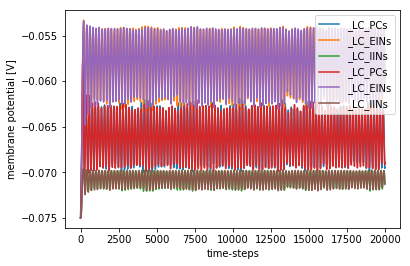

In [79]:
# simulation parametrization
############################

# base parameters
step_size = 5e-4
max_synaptic_delay = 0.5
n_circuits = 2
n_populations = 6
n_synapses = 2

# simulation parameters
simulation_time = 10.
simulation_steps = int(simulation_time/step_size)

# synapse parameters
synapse_params_e = {'efficacy':3.182e-13, 'tau_rise': 3e-4, 'tau_decay': 6e-3}
synapse_params_i = {'efficacy':-1.273e-12, 'tau_rise': 6e-4, 'tau_decay': 2e-2}
synapse_params = None

# connectivity parameters
c1 = 20.
c2 = 20.
connectivity = np.zeros((n_circuits, n_circuits, n_synapses))
connectivity[0, 1, 0] = c1
connectivity[1, 0, 0] = c2

# delay parameters
d1 = 0.
d2 = 0.
delays = np.zeros((n_circuits, n_circuits))
delays[0, 1] = d1
delays[1, 0] = d2

# synaptic input
min_input = 120
max_input = 320
synaptic_input = np.zeros((simulation_steps, n_populations, n_synapses))
synaptic_input[:, 0, 0] = np.random.uniform(min_input, max_input, simulation_steps)
synaptic_input[:, 3, 0] = np.random.uniform(min_input, max_input, simulation_steps)

# initialize network
####################

# Jansen-Rit circuits
jrc1 = JansenRitLeakyCapacitorCircuit(step_size=step_size, max_synaptic_delay=max_synaptic_delay, 
                                      synapse_params=synapse_params)
jrc2 = JansenRitLeakyCapacitorCircuit(step_size=step_size, max_synaptic_delay=max_synaptic_delay, 
                                      synapse_params=synapse_params)

# combined network
jrc_comb = CircuitFromCircuit([jrc1, jrc2], connectivity, delays)

# simulate network behavior
###########################

# run simulation
jrc_comb.run(synaptic_input, simulation_time)

# collect desired population states
pops = [0, 1, 2, 3, 4, 5]
states = jrc_comb.get_population_states(0, pops)

# plot results
jrc_comb.plot_population_states(pops, create_plot=False)

Creating RawArray with float64 data, n_channels=2, n_times=20001
    Range : 0 ... 20000 =      0.000 ...    10.000 secs
Ready.
1 matching events found
0 projection items activated
0 bad epochs dropped
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)


(2.0, 100.0)

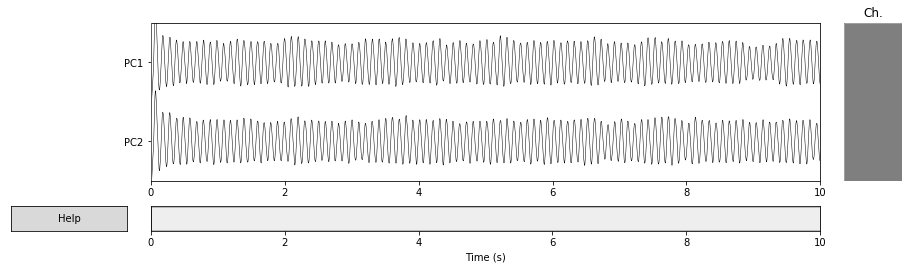

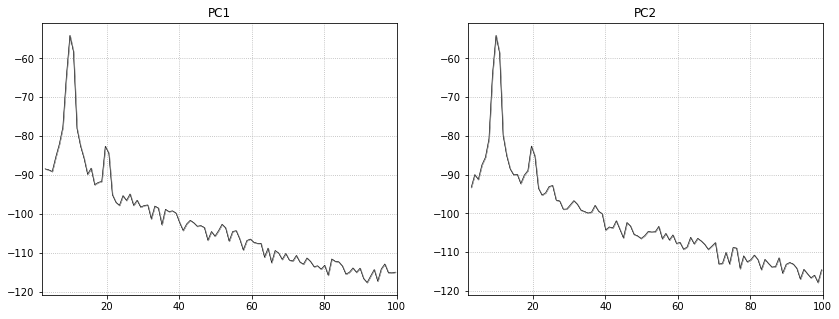

In [80]:
# create mne object
###################

# Definition of channel types and names.
ch_types = ['eeg', 'eeg']
ch_names = ['PC1', 'PC2']

# create info object
info = mne.create_info(ch_names=ch_names, sfreq=1./step_size, ch_types=ch_types)

# specify events
events = np.array([[200, 0, 1]])
event_id={'Dummy': 1}

# transform data
data = states[:, [0, 3]].T # select only PCs
data_epochs = np.reshape(data, (1, data.shape[0], data.shape[1])) # add first dimension (epochs)

# create raw data object
raw = mne.io.RawArray(data, info=info)
epochs = mne.EpochsArray(data_epochs, info=info, events=events, event_id=event_id)

# plot raw data
###############

# data scaling
scalings = {'eeg': 0.005}

# plotting
fig = raw.plot(n_channels=2, scalings=scalings, title='Raw Simulation Data',
               show=False, block=True)
fig.set_size_inches(14, 4, forward=True)

# plot PSD
###########

# frequency range
fmin = 2.
fmax = 100.

# data range
tmin = 1.
tmax = 10.

# FFT size
nfft = 2048

# select channels
picks = mne.pick_types(raw.info, meg=False, eeg=True)

# plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig = raw.plot_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, n_fft=nfft, n_jobs=1, 
                   proj=False, show=False, average=True, area_mode='range', picks=[0], ax=axes[0])
axes[0]. set_title('PC1')
axes[0].set_xlim(fmin, fmax)
fig = raw.plot_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, n_fft=nfft, n_jobs=1, 
                   proj=False, show=False, average=True, area_mode='range', picks=[1], ax=axes[1])
axes[1].set_title('PC2')
axes[1].set_xlim(fmin, fmax)

In [81]:
# estimate coherence between Jansen-Rit circuits in specifiec frequency band
############################################################################

fmin = 8.
fmax = 13.

connections=(np.array([0, 1]), np.array([1, 0]))
coh, freqs, times, n_epochs, n_tapers = spectral_connectivity(data_epochs, method='coh', mode='multitaper', sfreq=1/step_size,
                                                              fmin=fmin, fmax=fmax, faverage=True, n_jobs=1, indices=connections)

print('Coherence between JRC1 and JRC2 between ', freqs[0][0], ' and ', freqs[0][-1], ' Hz. = ', coh[0])

Connectivity computation...
    computing connectivity for 2 connections
    using t=0.000s..10.000s for estimation (20001 points)
    frequencies: 8.1Hz..13.0Hz (50 points)
    connectivity scores will be averaged for each band
    using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
[Connectivity computation done]
Coherence between JRC1 and JRC2 between  8.09959502025  and  12.9993500325  Hz. =  [ 0.70060707]


In [ ]:
# visualize 